# Cancer Severity Prediction Project

This is a linear regression project to predict cancer severity score. I chose to mainly use PySpark in an attempt to familiarize myself with it for data science purposes. The target variable, cancer severity score, is a continuous numeric variable ranging from 0.9-9.16, with the larger values being more severe. Sidenote: You will see some Pandas come up here and there throughout the project, but it's merely utilized as a means to an end and each pd dataframe is converted back into a PySpark DF as soon as possible.

### Load Data In and Do Some EDA

In [1]:
#Import packages and spin up Spark session
from pyspark.sql import SparkSession, Row, DataFrame
from pyspark.sql.functions import isnan, when, count, col, udf
from pyspark.ml import Pipeline
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder, UnivariateFeatureSelector, PCA
import seaborn as sns 
import matplotlib.pyplot as plt
from pyspark.sql.types import ArrayType, DoubleType
import os
from typing import Dict, List
from pyspark.sql import functions as F
from sklearn.feature_selection import RFE
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import LinearRegression, RandomForestRegressor
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
from pyspark.ml.linalg import Vectors
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.svm import SVR
import pylab
from sklearn.metrics import mean_squared_error

spark = SparkSession.builder.master("local[1]").appName("SparkByExamples.com").getOrCreate()

25/05/25 11:22:37 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [3]:
#File location and type
file_location = "global_cancer_patients_2015_2024.csv"
file_type = "csv"

#CSV options
infer_schema = "true"
first_row_is_header = "true"
delimiter = ","

#The applied options are for CSV files. For other file types, these will be ignored.
df = spark.read.format(file_type) \
  .option("inferSchema", infer_schema) \
  .option("header", first_row_is_header) \
  .option("sep", delimiter) \
  .load(file_location)

#Cache data for faster reuse
df.cache() 

DataFrame[Patient_ID: string, Age: int, Gender: string, Country_Region: string, Year: int, Genetic_Risk: double, Air_Pollution: double, Alcohol_Use: double, Smoking: double, Obesity_Level: double, Cancer_Type: string, Cancer_Stage: string, Treatment_Cost_USD: double, Survival_Years: double, Target_Severity_Score: double]

In [4]:
df.show(n = 5)

[Stage 2:>                                                          (0 + 1) / 1]

+----------+---+------+--------------+----+------------+-------------+-----------+-------+-------------+-----------+------------+------------------+--------------+---------------------+
|Patient_ID|Age|Gender|Country_Region|Year|Genetic_Risk|Air_Pollution|Alcohol_Use|Smoking|Obesity_Level|Cancer_Type|Cancer_Stage|Treatment_Cost_USD|Survival_Years|Target_Severity_Score|
+----------+---+------+--------------+----+------------+-------------+-----------+-------+-------------+-----------+------------+------------------+--------------+---------------------+
| PT0000000| 71|  Male|            UK|2021|         6.4|          2.8|        9.5|    0.9|          8.7|       Lung|   Stage III|          62913.44|           5.9|                 4.92|
| PT0000001| 34|  Male|         China|2021|         1.3|          4.5|        3.7|    3.9|          6.3|   Leukemia|     Stage 0|          12573.41|           4.7|                 4.65|
| PT0000002| 80|  Male|      Pakistan|2023|         7.4|          7.9|

In [5]:
#Display dataframe with count of nan/null for each column
df.select([count(when(isnan(c), c)).alias(c) for c in df.columns]).show()

[Stage 3:>                                                          (0 + 1) / 1]

+----------+---+------+--------------+----+------------+-------------+-----------+-------+-------------+-----------+------------+------------------+--------------+---------------------+
|Patient_ID|Age|Gender|Country_Region|Year|Genetic_Risk|Air_Pollution|Alcohol_Use|Smoking|Obesity_Level|Cancer_Type|Cancer_Stage|Treatment_Cost_USD|Survival_Years|Target_Severity_Score|
+----------+---+------+--------------+----+------------+-------------+-----------+-------+-------------+-----------+------------+------------------+--------------+---------------------+
|         0|  0|     0|             0|   0|           0|            0|          0|      0|            0|          0|           0|                 0|             0|                    0|
+----------+---+------+--------------+----+------------+-------------+-----------+-------+-------------+-----------+------------+------------------+--------------+---------------------+



In [6]:
#Drop duplicates, if any
df.dropDuplicates().show()

+----------+---+------+--------------+----+------------+-------------+-----------+-------+-------------+-----------+------------+------------------+--------------+---------------------+
|Patient_ID|Age|Gender|Country_Region|Year|Genetic_Risk|Air_Pollution|Alcohol_Use|Smoking|Obesity_Level|Cancer_Type|Cancer_Stage|Treatment_Cost_USD|Survival_Years|Target_Severity_Score|
+----------+---+------+--------------+----+------------+-------------+-----------+-------+-------------+-----------+------------+------------------+--------------+---------------------+
| PT0000035| 37|Female|        Brazil|2018|         2.8|          2.2|        3.2|    4.8|          3.5|   Prostate|    Stage II|          85569.18|           2.2|                 2.97|
| PT0000568| 37|Female|        Brazil|2020|         7.6|          5.5|        4.0|    9.6|          4.3|   Leukemia|     Stage I|          96585.91|           3.8|                 5.36|
| PT0000575| 68| Other|       Germany|2024|         7.5|          6.7|

In [7]:
#Remove ID column as its superfluous 
df = df.drop('Patient_ID')

In [8]:
#Print column types
for col_name, col_type in df.dtypes:
        print(f"Column Name: {col_name}, Column Type: {col_type}")

Column Name: Age, Column Type: int
Column Name: Gender, Column Type: string
Column Name: Country_Region, Column Type: string
Column Name: Year, Column Type: int
Column Name: Genetic_Risk, Column Type: double
Column Name: Air_Pollution, Column Type: double
Column Name: Alcohol_Use, Column Type: double
Column Name: Smoking, Column Type: double
Column Name: Obesity_Level, Column Type: double
Column Name: Cancer_Type, Column Type: string
Column Name: Cancer_Stage, Column Type: string
Column Name: Treatment_Cost_USD, Column Type: double
Column Name: Survival_Years, Column Type: double
Column Name: Target_Severity_Score, Column Type: double


In [9]:
#Convert stage column to numeric type to add to correlation matrix
df_with_stage_num = df.withColumn(
    "StageNum",
    when(df["Cancer_Stage"] == "Stage 0", 0)
    .when(df["Cancer_Stage"] == "Stage I", 1)
    .when(df["Cancer_Stage"] == "Stage II", 2)
    .when(df["Cancer_Stage"] == "Stage III", 3)
    .when(df["Cancer_Stage"] == "Stage IV", 4)
    .otherwise(5)
)

In [10]:
#Replacing original DF with stage num as a numeric variable and removing categorical var
selected_columns = ["Age", "Year", "Genetic_Risk", "Air_Pollution", "Alcohol_Use", "Smoking",
                   "Obesity_Level", "Treatment_Cost_USD", "Survival_Years", "Target_Severity_Score",
                   "StageNum"]
new_df_select = df_with_stage_num.select(*selected_columns)
new_df_select.show()

+---+----+------------+-------------+-----------+-------+-------------+------------------+--------------+---------------------+--------+
|Age|Year|Genetic_Risk|Air_Pollution|Alcohol_Use|Smoking|Obesity_Level|Treatment_Cost_USD|Survival_Years|Target_Severity_Score|StageNum|
+---+----+------------+-------------+-----------+-------+-------------+------------------+--------------+---------------------+--------+
| 71|2021|         6.4|          2.8|        9.5|    0.9|          8.7|          62913.44|           5.9|                 4.92|       3|
| 34|2021|         1.3|          4.5|        3.7|    3.9|          6.3|          12573.41|           4.7|                 4.65|       0|
| 80|2023|         7.4|          7.9|        2.4|    4.7|          0.1|           6984.33|           7.1|                 5.84|       2|
| 40|2015|         1.7|          2.9|        4.8|    3.5|          2.7|          67446.25|           1.6|                 3.12|       1|
| 43|2017|         5.1|          2.8|    

Correlation matrix shown below to check for any potential multicollinearity. Based on the visual, none of the variables are so highly correlated with our target variable that an eyebrow would theoretically be raised. 

In [11]:
#Convert to vector column first
vector_col = "corr_features"
assembler = VectorAssembler(inputCols=new_df_select.columns, outputCol=vector_col)
df_vector = assembler.transform(new_df_select).select(vector_col)

#Get correlation matrix
matrix = Correlation.corr(df_vector, vector_col)

25/05/25 11:23:29 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
25/05/25 11:23:29 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS
                                                                                

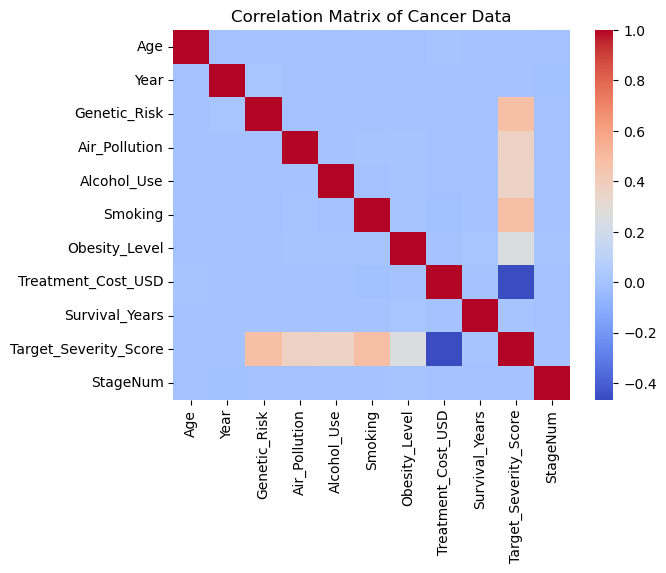

In [12]:
#Correlation matrix visual
cor_np = matrix.collect()[0][matrix.columns[0]].toArray()

feature_cols = new_df_select.columns

sns.heatmap(cor_np, xticklabels=feature_cols, yticklabels=feature_cols, annot=False, cmap="coolwarm")
plt.title("Correlation Matrix of Cancer Data")
plt.show()

QQ plots for every numeric variable in our dataframe shown below to check for skewness. Unfortunately, they all ended up being very skewed so all were log transformed (shoutout my Kantian pandas and numpy packages) and then plotted again to check for normality. They still weren't particularly "normal" (same), but still figured it would be worth it to try to transform them to see if it had any positive effect. 

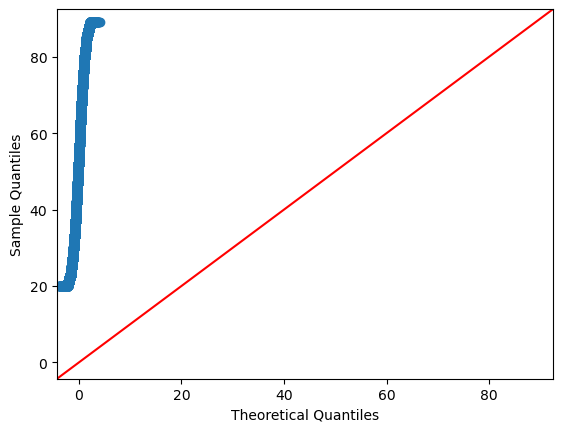

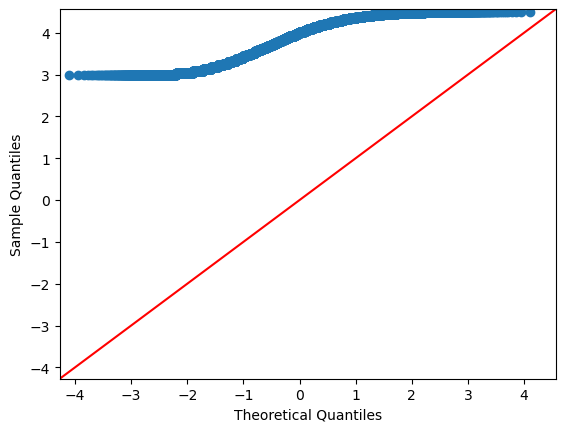

In [31]:
age = new_df_select.select('Age')
age_df = age.toPandas()

age_df['ln_Age'] = np.log(age_df['Age'])

sm.qqplot(age_df['Age'], line='45')
pylab.show()

sm.qqplot(age_df['ln_Age'], line='45')
pylab.show()

/Users/allisonking/opt/anaconda3/envs/latest-python/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


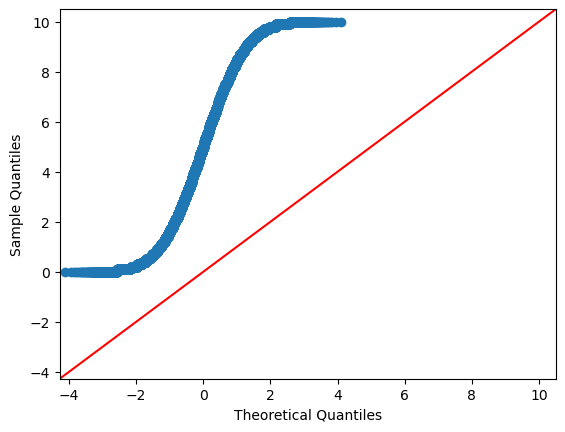

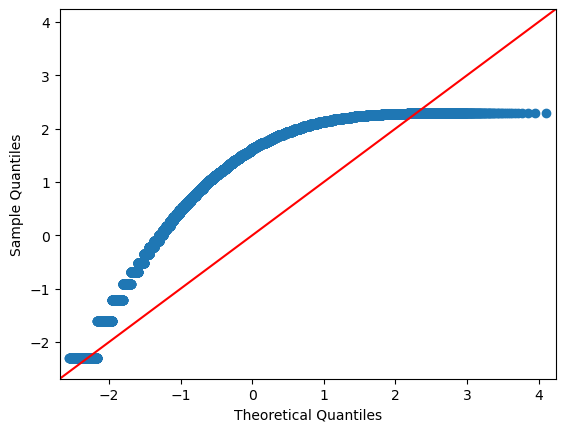

In [30]:
genetic_risk = new_df_select.select('Genetic_Risk')
gr_df = genetic_risk.toPandas()

gr_df['ln_Genetic_Risk'] = np.log(gr_df['Genetic_Risk'])

sm.qqplot(gr_df['Genetic_Risk'], line='45')
pylab.show()

sm.qqplot(gr_df['ln_Genetic_Risk'], line='45')
pylab.show()

/Users/allisonking/opt/anaconda3/envs/latest-python/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


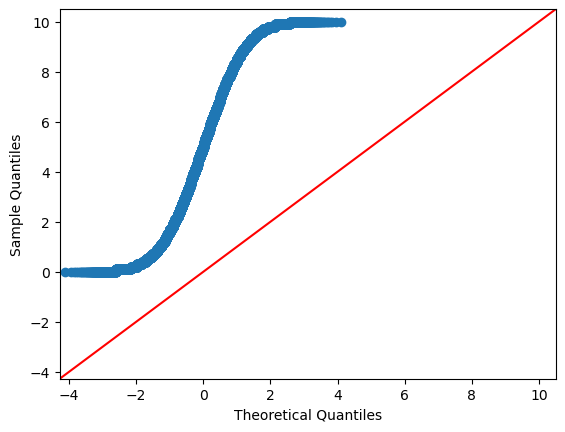

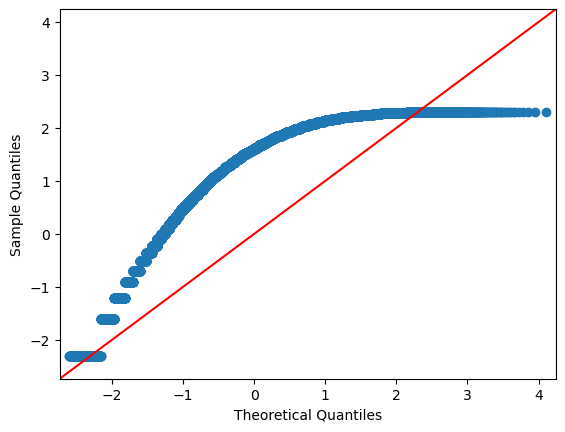

In [32]:
airp = new_df_select.select('Air_Pollution')
air_df = airp.toPandas()

air_df['ln_Air_Pollution'] = np.log(air_df['Air_Pollution'])

sm.qqplot(air_df['Air_Pollution'], line='45')
pylab.show()

sm.qqplot(air_df['ln_Air_Pollution'], line='45')
pylab.show()

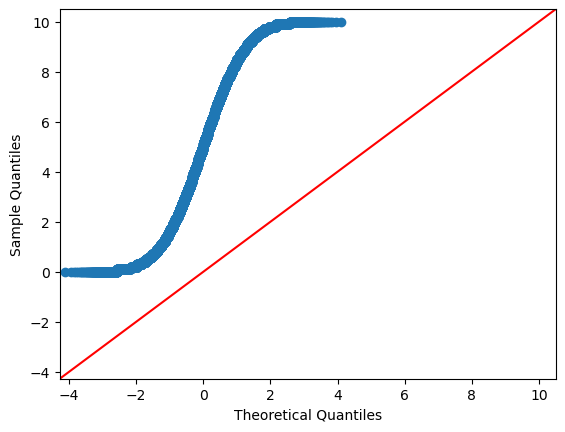

/Users/allisonking/opt/anaconda3/envs/latest-python/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


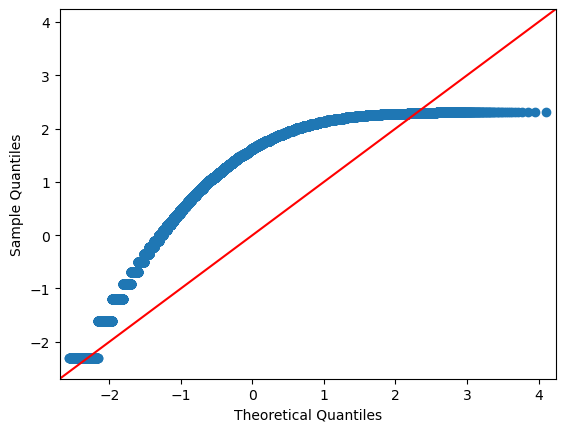

In [33]:
alc = new_df_select.select('Alcohol_Use')
alc_df = alc.toPandas()

sm.qqplot(alc_df['Alcohol_Use'], line='45')
pylab.show()

alc_df['ln_Alcohol_Use'] = np.log(alc_df['Alcohol_Use'])

sm.qqplot(alc_df['ln_Alcohol_Use'], line='45')
pylab.show()

/Users/allisonking/opt/anaconda3/envs/latest-python/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


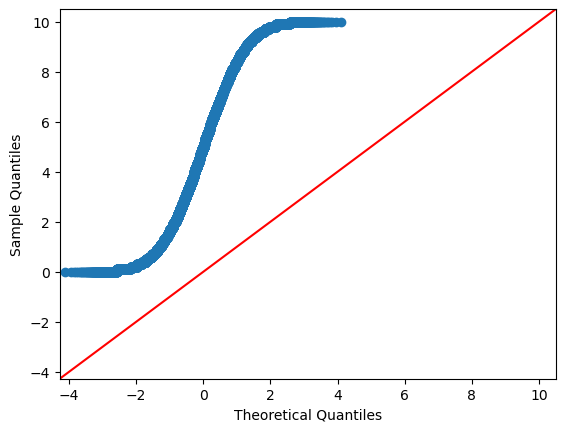

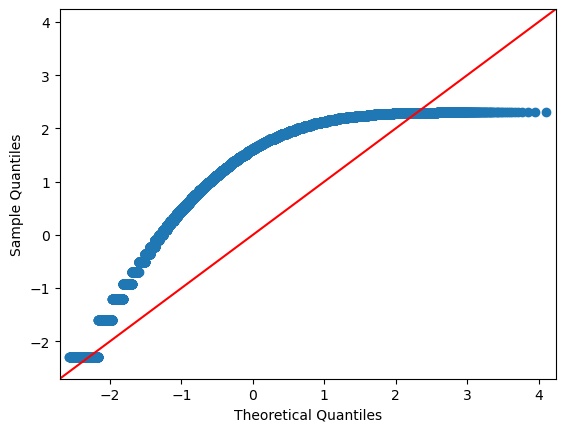

In [34]:
smoking = new_df_select.select('Smoking')
smoke = smoking.toPandas()

smoke['ln_Smoking'] = np.log(smoke['Smoking'])

sm.qqplot(smoke['Smoking'], line='45')
pylab.show()

sm.qqplot(smoke['ln_Smoking'], line='45')
pylab.show()

/Users/allisonking/opt/anaconda3/envs/latest-python/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


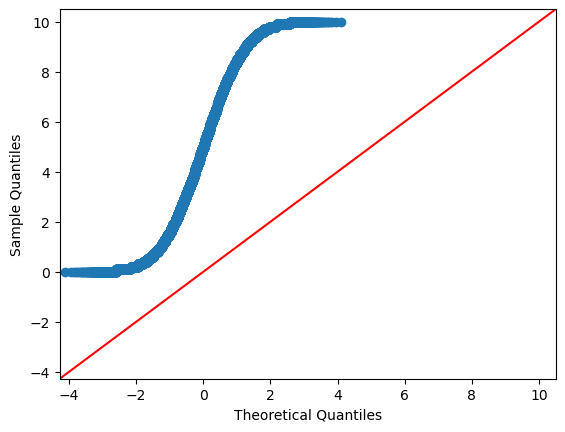

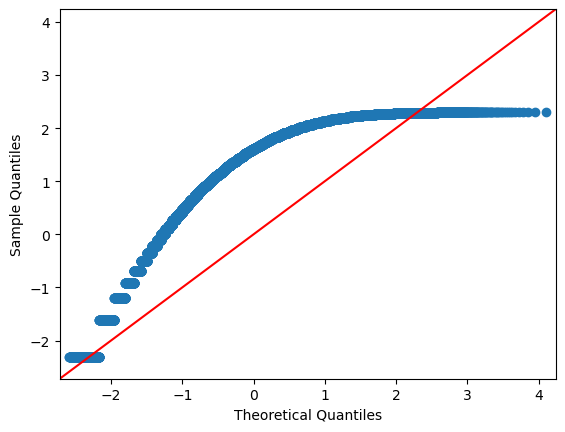

In [35]:
ob = new_df_select.select('Obesity_Level')
ob_df = ob.toPandas()

ob_df['ln_obs'] = np.log(ob_df['Obesity_Level'])

sm.qqplot(ob_df['Obesity_Level'], line='45')
pylab.show()

sm.qqplot(ob_df['ln_obs'], line='45')
pylab.show()

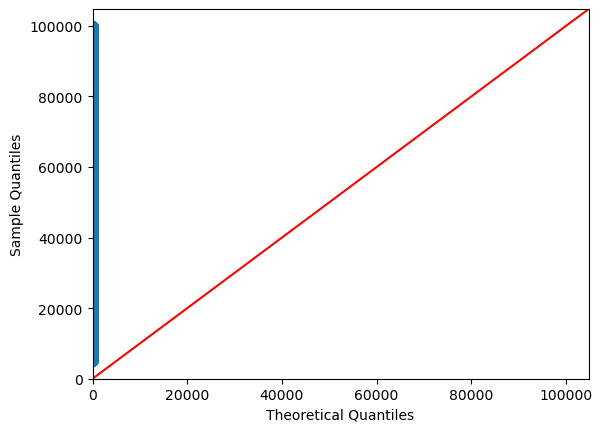

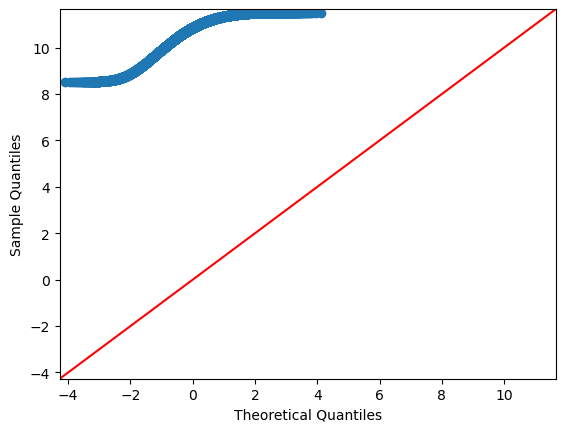

In [36]:
tcm = new_df_select.select('Treatment_Cost_USD')
tcm_df = tcm.toPandas()

tcm_df['ln_treat'] = np.log(tcm_df['Treatment_Cost_USD'])

sm.qqplot(tcm_df['Treatment_Cost_USD'], line='45')
pylab.show()

sm.qqplot(tcm_df['ln_treat'], line='45')
pylab.show()

/Users/allisonking/opt/anaconda3/envs/latest-python/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


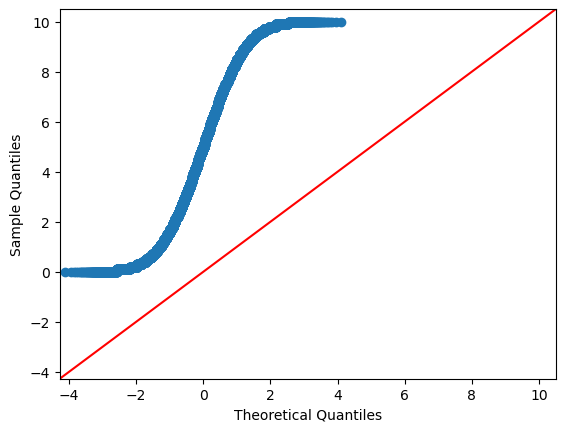

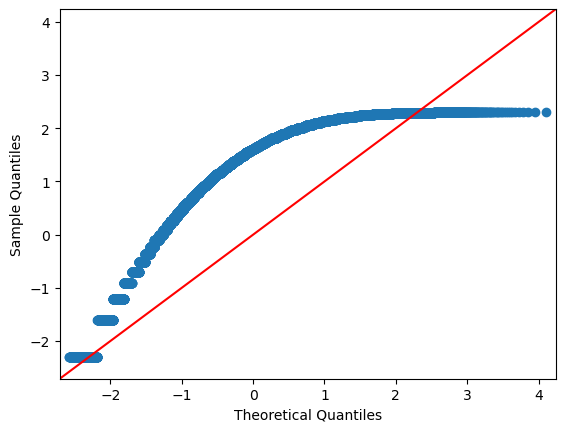

In [37]:
yrs = new_df_select.select('Survival_Years')
survive_df = yrs.toPandas()

survive_df['ln_sy'] = np.log(survive_df['Survival_Years'])

sm.qqplot(survive_df['Survival_Years'], line='45')
pylab.show()

sm.qqplot(survive_df['ln_sy'], line='45')
pylab.show()

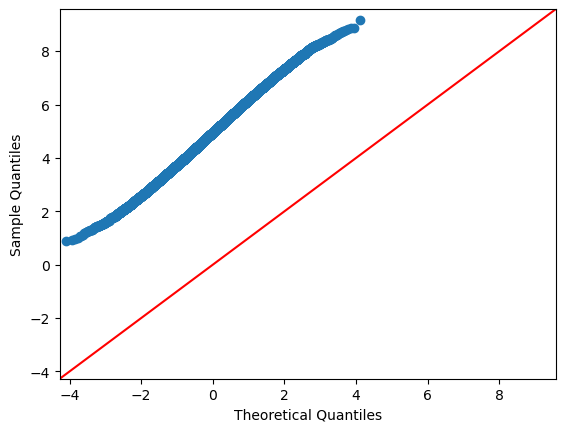

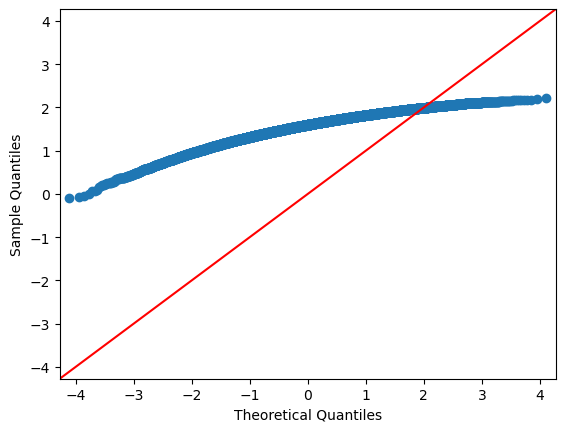

In [38]:
tar = new_df_select.select('Target_Severity_Score')
tar_df = tar.toPandas()

tar_df['ln_tar'] = np.log(tar_df['Target_Severity_Score'])

sm.qqplot(tar_df['Target_Severity_Score'], line='45')
pylab.show()

sm.qqplot(tar_df['ln_tar'], line='45')
pylab.show()

### One-Hot Encoding + PCA (.... I know PCA is technically EDA but needed to one-hot encode the categorical variables first)

One-hot encode the categorical variables. We can't do math with words, right?

In [39]:
#Class that mimics the sklearn API - I did not write this myself!! 
class PysparkOnehotEncoder:
    def __init__(self):
        self.conditions: Dict[str, Dict[str, int]] = {}
        self.categories: Dict[str, Dict[str, int]] = {}

    def fit(self, df: DataFrame, cat_cols: List[str]) -> None:
        for col in cat_cols:
            cats = df.select(col).distinct().collect()
            length = len(cats)
            cats: List[str] = [df.select(col).distinct().collect()[cat][0] for cat  in range(length)]

            self.conditions[col] = {}
            self.categories[col] = {}
            for idx, cat in enumerate(cats):
                self.conditions[col][f"{col} == '{cat}'"] = idx
                self.categories[col][cat] = idx # useful for reverse_transform at some point

    def predict(self, df: DataFrame) -> DataFrame:
        for col, cats_dict in self.categories.items():
            for cat, _idx in cats_dict.items():
                
                expression = F.expr(f"CASE WHEN {col} == '{cat}' THEN 1 ELSE 0 END")

                df = df.withColumn(str(col) + "_" + str(cat), F.lit(0))
                df = df.withColumn(str(col) + "_" + str(cat), expression)
            df = df.drop(col)
        return df

    def fit_predict(self, df: DataFrame, cat_cols: List[str]):
        self.fit(df, cat_cols)
        df = self.predict(df)
        return df

In [40]:
#Remove stage column as we converted it from string to numeric 
df_with_stage_num = df_with_stage_num.drop('Cancer_Stage')

In [41]:
#Instantiate the class, run fit method, transform the new df
onehot_encoder = PysparkOnehotEncoder()

onehot_encoder.fit(df_with_stage_num, ["Gender", "Country_Region", "Cancer_Type"])

pred_df = onehot_encoder.predict(df_with_stage_num)
pred_df.show(n=5)

25/05/25 11:46:39 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+---+----+------------+-------------+-----------+-------+-------------+------------------+--------------+---------------------+--------+-------------+------------+-----------+---------------------+----------------------+--------------------+--------------------+------------------+-----------------+---------------------+---------------------+------------------------+-----------------------+----------------+-----------------+--------------------+--------------------+--------------------+-----------------+----------------+------------------+
|Age|Year|Genetic_Risk|Air_Pollution|Alcohol_Use|Smoking|Obesity_Level|Treatment_Cost_USD|Survival_Years|Target_Severity_Score|StageNum|Gender_Female|Gender_Other|Gender_Male|Country_Region_Russia|Country_Region_Germany|Country_Region_China|Country_Region_India|Country_Region_USA|Country_Region_UK|Country_Region_Canada|Country_Region_Brazil|Country_Region_Australia|Country_Region_Pakistan|Cancer_Type_Skin|Cancer_Type_Colon|Cancer_Type_Prostate|Cancer_

PCA results shown below. Used this to extract the most informative features from the dataset/features that explained the most variation in our data. PC3 looks the most interesting for our purposes, as I interpret this PC to demonstrate that obesity level, survival years, alcohol use, air pollution and smoking are primary measurements of cancer severity in patients. 

In [16]:
#PCA 
unsup = pred_df.drop('Target_Severity_Score')

assembler = VectorAssembler(
     inputCols=unsup.columns,
     outputCol="features")

data = assembler.transform(unsup)


no_of_components = 5
pca = PCA(k=no_of_components, inputCol="features", outputCol="pcaFeatures")
model = pca.fit(data)
result = model.transform(data).select("pcaFeatures")
result.show(truncate=False)

25/05/24 21:31:32 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeSystemLAPACK
25/05/24 21:31:32 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeRefLAPACK


+-------------------------------------------------------------------------------------------------+
|pcaFeatures                                                                                      |
+-------------------------------------------------------------------------------------------------+
|[-62913.440191003036,70.09228008948868,-215.1213733927082,-874.6738050145799,386.6579810916108]  |
|[-12573.41009300964,33.230237580143026,-217.29524647167534,-868.1105230879638,383.2088764695553] |
|[-6984.330210898155,79.24989364346202,-220.47728582828503,-871.2249362005417,382.1941678372343]  |
|[-67446.25011012614,39.08739219863038,-220.6709429118905,-864.8123576370963,384.21876269120577]  |
|[-77977.12011492068,42.06208383328438,-222.29226337142205,-866.5161683556221,380.6875716680665]  |
|[-33468.990056994,21.178904309423793,-216.17731911992954,-873.0646123955005,379.8639063958328]   |
|[-9790.830109842193,40.243344110776405,-221.5701547320799,-867.8108709875477,383.0694614398769]  |


In [17]:
model.pc.toArray()

array([[-2.65443764e-06,  9.99999481e-01,  3.38167791e-04,
        -2.11953562e-04,  5.63999913e-04],
       [-6.35527686e-09, -3.63012786e-04, -1.12540415e-01,
        -4.28747273e-01,  1.89858870e-01],
       [ 2.49461576e-07,  3.25811197e-04, -8.26716899e-02,
        -7.18980416e-01, -1.66822918e-01],
       [ 7.98652367e-07,  1.64421434e-04,  4.05855795e-01,
         2.26686532e-01,  2.61012488e-01],
       [ 3.80875834e-07, -6.00354520e-04,  3.24565247e-01,
        -1.06587603e-01,  7.39828144e-01],
       [ 9.65536340e-07,  2.57015420e-04,  2.67489066e-01,
         3.47135716e-01, -4.06153410e-01],
       [ 1.32341496e-07, -3.94781051e-04,  7.20794983e-01,
        -2.44111334e-01, -1.42535082e-01],
       [-1.00000000e+00, -2.65431495e-06,  7.96755443e-07,
         2.57358827e-07,  1.77499851e-08],
       [ 4.52475805e-08, -2.12850705e-05,  3.45442277e-01,
        -2.37417099e-01, -3.67920286e-01],
       [ 1.34182004e-07, -2.31135174e-04,  2.78069639e-03,
         5.34684795e-03

In [18]:
pd.options.display.float_format = '{:.5f}'.format
loading_scores = pd.DataFrame(model.pc.toArray(),columns = [f"PCA{i}" for i in range(1, len(model.pc.toArray()[0])+1)])
loading_scores['Variable'] = unsup.columns
print(loading_scores)

       PCA1     PCA2     PCA3     PCA4     PCA5                  Variable
0  -0.00000  1.00000  0.00034 -0.00021  0.00056                       Age
1  -0.00000 -0.00036 -0.11254 -0.42875  0.18986                      Year
2   0.00000  0.00033 -0.08267 -0.71898 -0.16682              Genetic_Risk
3   0.00000  0.00016  0.40586  0.22669  0.26101             Air_Pollution
4   0.00000 -0.00060  0.32457 -0.10659  0.73983               Alcohol_Use
5   0.00000  0.00026  0.26749  0.34714 -0.40615                   Smoking
6   0.00000 -0.00039  0.72079 -0.24411 -0.14254             Obesity_Level
7  -1.00000 -0.00000  0.00000  0.00000  0.00000        Treatment_Cost_USD
8   0.00000 -0.00002  0.34544 -0.23742 -0.36792            Survival_Years
9   0.00000 -0.00023  0.00278  0.00535 -0.00146                  StageNum
10  0.00000 -0.00015  0.00084  0.00008 -0.00128             Gender_Female
11 -0.00000  0.00009 -0.00025 -0.00006  0.00079              Gender_Other
12 -0.00000  0.00006 -0.00059 -0.00002

### Feature Selection

Recursive Feature Elimination was used for feature selection for this project. In the past I've used a combination of a random forest model and hand picking the categorical variables I thought would be the most interesting, but this time wanted to try something new. It took 5ever to run but it was definitely cool to try and gave me a good selection!

In [19]:
#RFE For Feature Selection
X = pred_df.drop('Target_Severity_Score')
y = pred_df.select('Target_Severity_Score')

X_df = X.toPandas()
y_df = y.toPandas()

x_arr = X_df.values
y_arr = y_df.values

estimator = SVR(kernel="linear")
selector = RFE(estimator, n_features_to_select=15, step=1)
selector = selector.fit(x_arr, y_arr)
selector.support_
selector.ranking_

/Users/allisonking/opt/anaconda3/envs/latest-python/lib/python3.13/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/allisonking/opt/anaconda3/envs/latest-python/lib/python3.13/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/allisonking/opt/anaconda3/envs/latest-python/lib/python3.13/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/allisonking/opt/anaconda3/envs/latest-python/lib/python3.13/site-packages/sklearn

array([16,  7,  1,  1,  1,  1,  1, 17, 15, 11,  1,  1,  6,  1,  1,  1,  2,
        1,  8,  1, 14,  1, 12,  9, 10,  1, 13,  4,  3,  1,  5])

In [23]:
print(X_df.columns)

Index(['Age', 'Year', 'Genetic_Risk', 'Air_Pollution', 'Alcohol_Use',
       'Smoking', 'Obesity_Level', 'Treatment_Cost_USD', 'Survival_Years',
       'StageNum', 'Gender_Female', 'Gender_Other', 'Gender_Male',
       'Country_Region_Russia', 'Country_Region_Germany',
       'Country_Region_China', 'Country_Region_India', 'Country_Region_USA',
       'Country_Region_UK', 'Country_Region_Canada', 'Country_Region_Brazil',
       'Country_Region_Australia', 'Country_Region_Pakistan',
       'Cancer_Type_Skin', 'Cancer_Type_Colon', 'Cancer_Type_Prostate',
       'Cancer_Type_Cervical', 'Cancer_Type_Leukemia', 'Cancer_Type_Liver',
       'Cancer_Type_Lung', 'Cancer_Type_Breast'],
      dtype='object')


RFE found genetic risk, air pollution, alcohol use, smoking, obesity level, female gender, gender other, russia, germany, china, usa, canada, austalia, prostate cancer, and lung cancer to be the 15 most important variables.

### Log Transformations To Remove Skewness

In [86]:
#PySpark to pandas to log transform the numeric variables because of skewness
ln_df = pred_df.toPandas()

ln_df['Genetic_Risk'] = ln_df['Genetic_Risk'].replace(0, 0.00001)
ln_df['Air_Pollution'] = ln_df['Air_Pollution'].replace(0, 0.00001)
ln_df['Alcohol_Use'] = ln_df['Alcohol_Use'].replace(0, 0.00001)
ln_df['Smoking'] = ln_df['Smoking'].replace(0, 0.00001)
ln_df['Obesity_Level'] = ln_df['Obesity_Level'].replace(0, 0.00001)
ln_df['Target_Severity_Score'] = ln_df['Target_Severity_Score'].replace(0, 0.00001)

ln_df['ln_gr'] = np.log(ln_df['Genetic_Risk'])
ln_df['ln_ap'] = np.log(ln_df['Air_Pollution'])
ln_df['ln_au'] = np.log(ln_df['Alcohol_Use'])
ln_df['ln_smoke'] = np.log(ln_df['Smoking'])
ln_df['ln_ol'] = np.log(ln_df['Obesity_Level'])
ln_df['ln_tss'] = np.log(ln_df['Target_Severity_Score'])

#Drop untransformed columns
ln_df.drop(columns=['Genetic_Risk', 'Air_Pollution', 'Alcohol_Use', 'Smoking', 'Obesity_Level', 
                    'Target_Severity_Score'])

spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")
df = spark.createDataFrame(ln_df)

### Let's run our first model!

In [87]:
assembler = VectorAssembler(
    inputCols=['ln_gr', 'ln_ap', 'ln_au', 'ln_smoke', 'ln_ol', 
               'Gender_Female', 'Gender_Other', 'Country_Region_Russia', 'Country_Region_Germany',
               'Country_Region_China', 'Country_Region_USA', 'Country_Region_Canada', 
               'Country_Region_Australia', 'Cancer_Type_Prostate', 'Cancer_Type_Lung'],
    outputCol="features")

data = assembler.transform(df)

In [88]:
final_data = data.select("features", "ln_tss")
train_data, test_data = final_data.randomSplit([0.8, 0.2], seed=42)

In [89]:
lr = LinearRegression(featuresCol="features", labelCol="ln_tss", predictionCol="predicted_sev", regParam = 0.2)
lr_model = lr.fit(train_data)

25/05/25 12:25:46 WARN TaskSetManager: Stage 125 contains a task of very large size (10162 KiB). The maximum recommended task size is 1000 KiB.
25/05/25 12:25:46 WARN TaskSetManager: Stage 126 contains a task of very large size (10162 KiB). The maximum recommended task size is 1000 KiB.


In [90]:
predictions = lr_model.transform(test_data)
predictions.show()

25/05/25 12:25:48 WARN TaskSetManager: Stage 127 contains a task of very large size (10162 KiB). The maximum recommended task size is 1000 KiB.


+--------------------+------------------+------------------+
|            features|            ln_tss|     predicted_sev|
+--------------------+------------------+------------------+
|(15,[0,1,2,3],[-0...|1.4951487660319727|1.5386803167146268|
|(15,[0,1,2,3],[0....| 1.172482137234565|1.4996941139846323|
|(15,[0,1,2,3],[0....| 1.599387576580599| 1.558892584601949|
|(15,[0,1,2,3],[1....|1.4883995840570443|1.6013884268547929|
|(15,[0,1,2,3],[1....| 1.536867219599265| 1.564576386765473|
|(15,[0,1,2,3],[1....|1.6253112615903906|1.6167150262686591|
|(15,[0,1,2,3],[1....| 1.547562508716013| 1.583595724266019|
|(15,[0,1,2,3],[1....|1.7369512327330598|1.6130006600732747|
|(15,[0,1,2,3],[2....|1.8196988379172965|1.5980006411250818|
|(15,[0,1,2,3],[2....|1.5769147207285403|1.5835217331093916|
|(15,[0,1,2,3],[2....|1.6253112615903906|1.5961022528018112|
|(15,[0,1,2,3],[2....|1.5107219394949427|1.5742871724092513|
|(15,[0,1,2,3],[2....| 1.749199854809259|1.6404446309901515|
|(15,[0,1,2,3,4],[...|1.

In [91]:
#R2 for log transformed variables
evaluator_r2 = RegressionEvaluator(labelCol="ln_tss", predictionCol="predicted_sev", metricName="r2")
r2 = evaluator_r2.evaluate(predictions)
print("R-squared (R2) on test data: {:.3f}".format(r2))

R-squared (R2) on test data: 0.341


25/05/25 12:25:49 WARN TaskSetManager: Stage 128 contains a task of very large size (10162 KiB). The maximum recommended task size is 1000 KiB.


In [ ]:
#RMSE for model with log transformed variables
pandas_df = predictions.toPandas()
pandas_df.head()

mse_MLR = mean_squared_error(np.exp(pandas_df['ln_tss']), np.exp(pandas_df['predicted_sev']))
print(np.sqrt(mse_MLR))

In [93]:
predictions.show(n=5)

25/05/25 12:26:08 WARN TaskSetManager: Stage 130 contains a task of very large size (10162 KiB). The maximum recommended task size is 1000 KiB.


+--------------------+------------------+------------------+
|            features|            ln_tss|     predicted_sev|
+--------------------+------------------+------------------+
|(15,[0,1,2,3],[-0...|1.4951487660319727|1.5386803167146268|
|(15,[0,1,2,3],[0....| 1.172482137234565|1.4996941139846323|
|(15,[0,1,2,3],[0....| 1.599387576580599| 1.558892584601949|
|(15,[0,1,2,3],[1....|1.4883995840570443|1.6013884268547929|
|(15,[0,1,2,3],[1....| 1.536867219599265| 1.564576386765473|
+--------------------+------------------+------------------+
only showing top 5 rows



In [94]:
coefficients = lr_model.coefficients
intercept = lr_model.intercept

print("Coefficients: ", coefficients)
print("Intercept: {:.3f}".format(intercept))

Coefficients:  [0.0391884607515823,0.03178230255770767,0.029877075842710515,0.03932465704438667,0.020075564970725074,0.002474961111747832,0.00085299560874254,0.0015465439093923807,-0.0024876877093535834,-0.0011774712142240246,0.0024429108173406877,0.0004737920942120484,0.001351623029103802,-0.0016628025363863588,-0.0023469435023042253]
Intercept: 1.363


### Yikes that R^2.... let's try again but replace all the log transformed variables with the untransformed versions.

Trying to re-run model without any log transforming just to compare results!

In [139]:
assembler = VectorAssembler(
    inputCols=['Genetic_Risk', 'Air_Pollution', 'Alcohol_Use', 'Smoking', 'Obesity_Level', 
               'Gender_Female', 'Gender_Other', 'Country_Region_Russia', 'Country_Region_Germany',
               'Country_Region_China', 'Country_Region_USA', 'Country_Region_Canada', 
               'Country_Region_Australia', 'Cancer_Type_Prostate', 'Cancer_Type_Lung'],
    outputCol="features")

data = assembler.transform(pred_df)

final_data = data.select("features", "Target_Severity_Score")
train_data, test_data = final_data.randomSplit([0.8, 0.2], seed=42)

In [140]:
lr = LinearRegression(featuresCol="features", labelCol="Target_Severity_Score", predictionCol="predicted_sev", regParam = 0.2)
lr_model = lr.fit(train_data)

In [141]:
predictions = lr_model.transform(test_data)
predictions.show()

+--------------------+---------------------+------------------+
|            features|Target_Severity_Score|     predicted_sev|
+--------------------+---------------------+------------------+
|(15,[0,1,2,3],[0....|                 1.91|2.7921892234035073|
|(15,[0,1,2,3],[2....|                 4.89|  4.55568887212708|
|(15,[0,1,2,3],[2....|                  3.0|3.6684563796202845|
|(15,[0,1,2,3],[4....|                  5.2| 5.255409083421136|
|(15,[0,1,2,3],[8....|                 6.12| 6.108143674095796|
|(15,[0,1,2,3,4],[...|                  3.8| 3.610777043308186|
|(15,[0,1,2,3,4],[...|                 3.66| 3.475747077274171|
|(15,[0,1,2,3,4],[...|                 2.59| 3.246355146785401|
|(15,[0,1,2,3,4],[...|                  3.9|3.9806975250927703|
|(15,[0,1,2,3,4],[...|                 3.86|  3.42452067418939|
|(15,[0,1,2,3,4],[...|                 4.94|   5.2105472575617|
|(15,[0,1,2,3,4],[...|                 3.25| 3.826292799660586|
|(15,[0,1,2,3,4],[...|                 3

In [142]:
evaluator = RegressionEvaluator(labelCol="Target_Severity_Score", predictionCol="predicted_sev", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data: {:.3f}".format(rmse))

evaluator_r2 = RegressionEvaluator(labelCol="Target_Severity_Score", predictionCol="predicted_sev", metricName="r2")
r2 = evaluator_r2.evaluate(predictions)
print("R-squared (R2) on test data: {:.3f}".format(r2))

Root Mean Squared Error (RMSE) on test data: 0.568
R-squared (R2) on test data: 0.775


### Much better! So far Elastic Net (alpha = 0.2) is a winner. Let's try a Random Forest challenger model to see how it compares.

Trying out random forest regression in PySpark.

In [119]:
random_forest_reg = RandomForestRegressor(featuresCol="features", labelCol="Target_Severity_Score")

model = random_forest_reg.fit(train_data)
predictions = model.transform(test_data)

predictions.show()

+--------------------+---------------------+------------------+
|            features|Target_Severity_Score|        prediction|
+--------------------+---------------------+------------------+
|(15,[0,1,2,3],[0....|                 1.91|3.2479317384259914|
|(15,[0,1,2,3],[2....|                 4.89| 4.912251126451682|
|(15,[0,1,2,3],[2....|                  3.0|  4.05225859753593|
|(15,[0,1,2,3],[4....|                  5.2| 5.083440339125416|
|(15,[0,1,2,3],[8....|                 6.12| 6.133067781931824|
|(15,[0,1,2,3,4],[...|                  3.8| 4.068372251372296|
|(15,[0,1,2,3,4],[...|                 3.66| 3.952810948598914|
|(15,[0,1,2,3,4],[...|                 2.59| 4.042112149447444|
|(15,[0,1,2,3,4],[...|                  3.9|  4.17717698595624|
|(15,[0,1,2,3,4],[...|                 3.86|  4.02518645091724|
|(15,[0,1,2,3,4],[...|                 4.94|  5.06247051044061|
|(15,[0,1,2,3,4],[...|                 3.25| 4.253324675492925|
|(15,[0,1,2,3,4],[...|                 3

In [120]:
evaluator = RegressionEvaluator(labelCol="Target_Severity_Score", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data: {:.3f}".format(rmse))

evaluator_r2 = RegressionEvaluator(labelCol="Target_Severity_Score", predictionCol="prediction", metricName="r2")
r2 = evaluator_r2.evaluate(predictions)
print("R-squared (R2) on test data: {:.3f}".format(r2))

Root Mean Squared Error (RMSE) on test data: 0.722
R-squared (R2) on test data: 0.637


In [134]:
importances = model.featureImportances
print(importances)

(15,[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14],[0.32090246329903444,0.15497971921321974,0.15470318171296418,0.31745778157392984,0.05159264849354149,3.296826251793571e-05,5.7112467546452303e-05,3.584254391313279e-05,2.9395552192313324e-05,3.0219438059893355e-05,3.069894213482111e-05,5.27557442099272e-05,1.3125951979607605e-05,6.219248329909331e-05,1.9894321457142043e-05])


Top 5 most important variables in descending order (mapped based on order of columns from previously transformed df): Genetic Risk, Smoking, Air Pollution, Alcohol Use, and Obesity Level.

### And the winner is....

Elastic Net with the lowest RMSE and highest R^2! Thanks everyone for reading.